In [1]:
# Mount the Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/FeedRecSys

/content/drive/My Drive/FeedRecSys


In [3]:
#unzip the archive file
# !unzip 16k_images-20220822T052208Z-001.zip

In [4]:
# all imports must go here
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import os
import shutil
import glob
import random
import cv2 as cv
import sys
from sklearn import manifold

In [ ]:
#Train and Validation folders created for setup

In [ ]:
# import os
# import shutil
source_folder = './16k_images'
train = './train/'
validation = 'validation/'

 

#Directory created and hence commented the code for single setup

In [ ]:

# path = os.path.join(source_folder, train) 
# os.mkdir(path) 
# print("Directory '% s' created" % train)

# path = os.path.join(source_folder, validation) 
# os.mkdir(path) 
# print("Directory '% s' created" % validation) 

#movement of files done, hence commented the code for initial setup one time

In [ ]:
# move 30% of files to validation folder and 70% to train()4810/len(files) * 100
# import random

# dest = validation
# files = os.listdir(source_folder)
# no_of_files = 4810      #len(files) // 3.7
# # print(no_of_files)
# for file_name in random.sample(files, no_of_files):
#     shutil.move(os.path.join(source_folder, file_name), dest)
#     # print(file_name)

In [ ]:
# dest = train
# files = os.listdir(source_folder)

# for file_name in files:
#     shutil.move(os.path.join(source_folder, file_name), dest)

In [ ]:
print(len(os.listdir('/content/drive/My Drive/FeedRecSys/train')))

11221


In [ ]:
print(len(os.listdir('/content/drive/My Drive/FeedRecSys/validation')))

4811


In [ ]:
print(len(os.listdir('/content/drive/My Drive/FeedRecSys/16k_images')))

0


In [ ]:
import tensorflow as tf
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
dir = source_folder
train_dir = os.path.join('/content/drive/My Drive/FeedRecSys/', dir)


train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode= None,
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)


Found 16032 files belonging to 1 classes.


In [ ]:
# dir1 = validation 
# valid_dir = os.path.join('/content/drive/My Drive/FeedRecSys/', dir1)

# validation_dataset = tf.keras.utils.image_dataset_from_directory(
#     valid_dir,
#     label_mode= None,
#     class_names=None,
#     color_mode='rgb',
#     batch_size=32,
#     image_size=(224, 224),
#     shuffle=True,
#     seed=None,
#     validation_split=None,
#     subset=None,
#     interpolation='bilinear',
#     follow_links=False,
#     crop_to_aspect_ratio=False
# )

Found 4810 files belonging to 1 classes.


In [ ]:
# class_names = train_dataset.class_names
# class_names

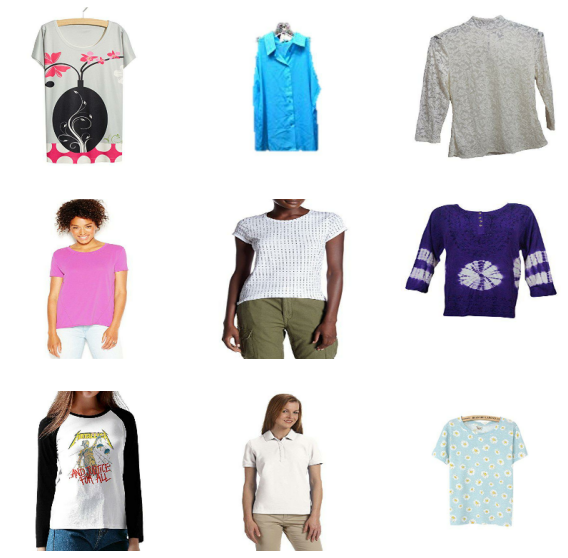

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))

    plt.axis("off")

In [ ]:
# val_batches = tf.data.experimental.cardinality(validation_dataset)
# test_dataset = validation_dataset.take(val_batches // 5)
# validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
# print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
# print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 121
Number of test batches: 30


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
# validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
# test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# data_augmentation = tf.keras.Sequential([
#   tf.keras.layers.RandomFlip('horizontal'),
#   tf.keras.layers.RandomRotation(0.2),
# ])

In [ ]:
preprocess_input = tf.keras.applications.xception.preprocess_input

In [ ]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)


In [ ]:
def construct_model(dataset):
  base_model = tf.keras.applications.xception.Xception(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
  image_batch = next(iter(dataset))
  feature_batch = base_model(image_batch)
  base_model.trainable = False
  return base_model,feature_batch


In [ ]:
# Let's take a look at the base model architecture
base_model, feature_batch = construct_model(train_dataset)
base_model.summary()

83697664/83683744 [==============================] - 0s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                   

# To generate vectors from the block of features, calculate the spatial average over (7,7) spatial locations using **tf.keras.layers.GlobalAveragePooling2D** layer to convert the features to a single 2048-element vector per image.

---



In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [ ]:
prediction_layer = tf.keras.layers.Dense(2048)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 2048)


In [ ]:
# from tensorflow.python.ops.gen_dataset_ops import model_dataset_eager_fallback
def construct_keras_model():
  inputs = tf.keras.Input(shape=(224, 224, 3))
  x = preprocess_input(inputs)
  x = base_model(x, training=False)
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)
  base_learning_rate = 0.0001
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  return model

In [ ]:
model = construct_keras_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

In [ ]:
len(model.trainable_variables)

2

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_xceptionmodel')

In [ ]:
train_files = os.listdir(os.path.join('/content/drive/My Drive/FeedRecSys/', source_folder))
# valid_files = os.listdir(os.path.join('/content/drive/My Drive/FeedRecSys/', dir1))


In [ ]:
def getFeatureVector(model, img_path):
  # print("imag_path=",img_path )
  img = cv.imread(img_path)
  img = cv.resize(img, (224, 224))
  img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
  feature_vector = model.predict(img.reshape(1, 224, 224, 3))

  # print(img_path + " is added.")
  return feature_vector


In [ ]:
train_dict = {}
# valid_dict = {}

In [ ]:
# for valid_file_name in valid_files:
#   # print(file_name)
#   valid_feature_vector = getFeatureVector(model, os.path.join('/content/drive/My Drive/FeedRecSys/validation', valid_file_name))
#   valid_dict.update({valid_file_name:valid_feature_vector[0]})

In [ ]:
# feature_vector = getFeatureVector(model, os.path.join('/content/drive/My Drive/FeedRecSys/16k_images', 'B074QX7M8V.jpeg'))
# feature_vector

array([[ 0.06106102, -0.0167836 , -0.9064268 , ...,  0.3082089 ,
        -0.34363165, -0.05653346]], dtype=float32)

In [ ]:
for file_name in tqdm(train_files):
  # print(file_name)
  feature_vector = getFeatureVector(model, os.path.join('/content/drive/My Drive/FeedRecSys/16k_images', file_name))
  train_dict.update({file_name:feature_vector})

100%|██████████| 16032/16032 [15:26<00:00, 17.30it/s]


In [ ]:
import pickle
# with open('trainxception_embed.pickle', 'wb') as f:
#         pickle.dump(train_dict, f)

In [5]:
import pickle
train_dict = pickle.load(open('trainxception_embed.pickle', 'rb'))




In [6]:
documents = []
vectors = []
for k,v in train_dict.items():
  documents.append(k)
  vectors.append(v[0])
len(documents),len(vectors)

print(type(vectors))
array_vec = np.asarray(vectors)

<class 'list'>


In [7]:
import time
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)

start_time = time.time()
X_tsne = tsne.fit_transform(array_vec) # fit and transfrom just like PCA
end_time = time.time()

print(end_time-start_time)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


146.0643756389618


In [8]:
def plot_embedding(X,  title=None):
    # min-max scaling
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], r'$\i='+str(i))

    if title is not None:
        plt.grid(True) # just added grid to interpret easily
        # plt.xscale("logit") # added this code
        plt.xlim((0,3)) # added this code
        plt.ylim((0,1.5)) # added this code
        plt.title(title)
    plt.show()

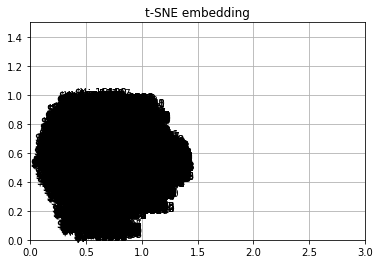

In [9]:
plot_embedding(X_tsne, "t-SNE embedding" )

In [10]:
tsne = manifold.TSNE(n_components=2, init='pca',perplexity=30, n_iter=2000, random_state=0, n_jobs=-1)

start_time = time.time()
X_tsne = tsne.fit_transform(array_vec) # fit and transfrom just like PCA
end_time = time.time()

print(end_time-start_time)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


267.1829822063446


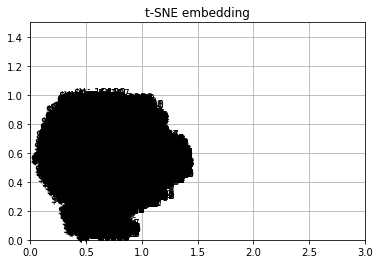

In [11]:
plot_embedding(X_tsne, "t-SNE embedding" )

#Terminate Run time in colab programmatically

In [ ]:
from google.colab import runtime
runtime.unassign()